In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import metrics
import random
from random import randint
import time
import os

## Preparing dataset:

In [75]:
# Useful Constants

# Output classes to learn how to classify
LABELS = [    
    "JUMPING",
    "JUMPING_JACKS",
    "BOXING",
    "WAVING_2HANDS",
    "WAVING_1HAND",
    "CLAPPING_HANDS"

] 
DATASET_PATH = "/content/drive/MyDrive/Colab Notebooks/OpenPose/datasets/"

X_train_path = DATASET_PATH + "X_train.txt"
X_test_path = DATASET_PATH + "X_test.txt"

y_train_path = DATASET_PATH + "Y_train.txt"
y_test_path = DATASET_PATH + "Y_test.txt"

X_val_path = DATASET_PATH + "X_val.txt"
n_steps = 32 # per frames

In [76]:
# Load the networks inputs

def load_X(X_path):
    file = open(X_path, 'r')
    X_ = np.array(
        [elem for elem in [
            row.split(',') for row in file
        ]], 
        dtype=np.float32
    )
    file.close()
    blocks = int(len(X_) / n_steps)
    
    X_ = np.array(np.split(X_,blocks))

    return X_ 

# Load the networks outputs

def load_y(y_path):
    file = open(y_path, 'r')
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # for 0-based indexing 
    return y_ - 1

X_train = load_X(X_train_path)
X_test = load_X(X_test_path)

X_val = load_X(X_val_path)
# print X_test

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

# proof that it actually works for the skeptical: replace labelled classes with random classes to train on
#for i in range(len(y_train)):
#    y_train[i] = randint(0, 5)


In [53]:
# 영상 개수 : 22625

X_train.shape
# (영상 개수, Target 프레임 수, 조인트 좌표(고정))

(22625, 32, 36)

In [54]:
# 총 프레임 개수 : 32
# 18개 joint의 x,y : 36개

X_train[0].shape

(32, 36)

In [55]:
# 프레임별 joint 좌표 : [j0_x, j0_y, j1_x, j1_y, ... j17_x, j17_y]

X_train[0] 

array([[295.914, 161.579, 307.693, ...,   0.   , 318.083, 161.632],
       [295.855, 161.6  , 307.684, ...,   0.   , 318.024, 161.654],
       [293.296, 161.62 , 307.655, ...,   0.   , 316.776, 161.679],
       ...,
       [291.986, 194.207, 307.671, ...,   0.   , 316.728, 194.234],
       [298.472, 182.52 , 308.965, ..., 183.804, 319.345, 181.236],
       [298.51 , 161.682, 310.234, ..., 162.982, 320.669, 161.676]],
      dtype=float32)

In [56]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [57]:
y_train

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

In [58]:
y_test

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

# LSTM Modeling

In [59]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

import keras.backend as K

In [60]:
n_input = 36 # 팔만 쓰기 때문에
# n_steps = 32 # per frames
n_hidden = 32
n_classes = len(LABELS)

epochs = 100
batch_size = 1024

## 1) Model define

In [61]:
K.clear_session()

model = Sequential()
model.add(Dense(n_hidden, activation='relu', input_shape=(n_steps, n_input)))
model.add(LSTM(n_hidden))
# model.add(LSTM(n_hidden))
model.add(Dense(n_classes, activation = 'softmax'))

In [62]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32, 32)            1184      
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 9,702
Trainable params: 9,702
Non-trainable params: 0
_________________________________________________________________


## 2) Model Compile

In [63]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## 3) Model Fit

In [64]:
%%time
hist = model.fit(X_train, y_train,
                 epochs = epochs,
                 batch_size = batch_size,
                 validation_data = (X_test, y_test))

Epoch 1/100
23/23 [==============================] - 2s 33ms/step - loss: 1.7494 - accuracy: 0.2524 - val_loss: 1.6550 - val_accuracy: 0.3641
Epoch 2/100
23/23 [==============================] - 0s 13ms/step - loss: 1.6197 - accuracy: 0.3715 - val_loss: 1.5809 - val_accuracy: 0.4401
Epoch 3/100
23/23 [==============================] - 0s 14ms/step - loss: 1.5221 - accuracy: 0.4540 - val_loss: 1.5026 - val_accuracy: 0.4371
Epoch 4/100
23/23 [==============================] - 0s 13ms/step - loss: 1.4368 - accuracy: 0.4607 - val_loss: 1.4434 - val_accuracy: 0.4658
Epoch 5/100
23/23 [==============================] - 0s 12ms/step - loss: 1.3950 - accuracy: 0.4872 - val_loss: 1.3609 - val_accuracy: 0.5114
Epoch 6/100
23/23 [==============================] - 0s 12ms/step - loss: 1.2934 - accuracy: 0.5518 - val_loss: 1.2777 - val_accuracy: 0.5728
Epoch 7/100
23/23 [==============================] - 0s 14ms/step - loss: 1.2103 - accuracy: 0.6143 - val_loss: 1.2018 - val_accuracy: 0.6175
Epoch 

## 4) Visualization(Loss, Accuracy)

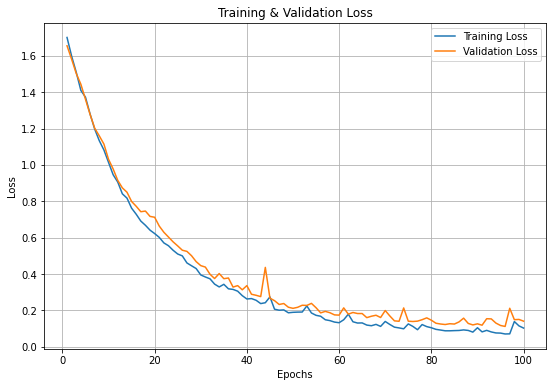

In [66]:
epochs = range(1, len(hist.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, hist.history['loss'])
plt.plot(epochs, hist.history['val_loss'])

plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()
plt.show()

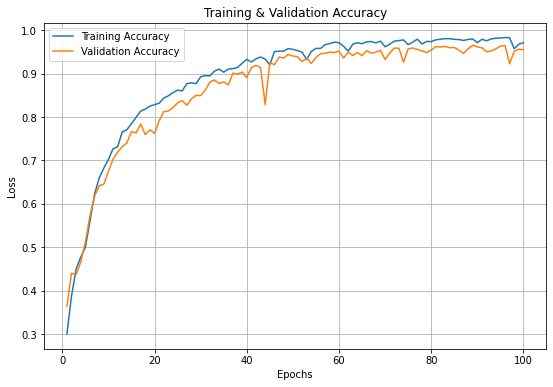

In [67]:

import matplotlib.pyplot as plt

epochs = range(1, len(hist.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, hist.history['accuracy'])
plt.plot(epochs, hist.history['val_accuracy'])

plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.grid()
plt.show()

## 5) Model Evaluate 

In [70]:
loss, accuracy = model.evaluate(X_test, y_test,
                                batch_size = batch_size)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

6/6 [==============================] - 0s 6ms/step - loss: 0.1412 - accuracy: 0.9550
Loss = 0.14118
Accuracy = 0.95496


In [78]:
X_val.shape

(1, 32, 36)

In [79]:
X_val

array([[[307.589, 162.976, 319.364, ...,   0.   , 329.752, 161.651],
        [307.567, 162.979, 319.362, ...,   0.   , 328.527, 161.655],
        [306.298, 162.951, 319.351, ...,   0.   , 328.495, 161.681],
        ...,
        [293.291, 122.534, 307.676, ..., 128.953, 315.438, 119.884],
        [289.392, 140.743, 307.615, ...,   0.   , 315.393, 139.408],
        [295.848, 161.658, 307.628, ..., 160.331, 314.112, 160.264]]],
      dtype=float32)

In [95]:
np.set_printoptions(precision=6, suppress=True) # np.array 표현 방식 변경 (지수 -> 실수)

predictions = model.predict(X_val)

predictions

array([[0.992479, 0.004868, 0.00039 , 0.00007 , 0.000071, 0.002122]],
      dtype=float32)

In [96]:
np.argmax(predictions[0], axis=-1)

0